In [150]:
import os 
os.environ["GIT_PYTHON_REFRESH"] = "quiet" 
#!module load git
import foolbox as fb
import torch
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples

In [151]:
import torchvision
from fastai.vision.all import *

Import the MNIST dataset and create the CNN class

In [152]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081))
])
train_set = torchvision.datasets.MNIST('./files/', train=True, download=True, transform=transforms)
test_set = torchvision.datasets.MNIST('./files/', train=False, download=True, transform=transforms)

In [153]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)

In [147]:
import torch.nn as nn
import torch.nn.functional as F

class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x)
        x = self.drop(self.conv2(x))
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
        

In [154]:
class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(F.max_pool2d(x, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 800)
        x = self.drop(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

Fastai takes the available device by default

In [155]:
data = DataLoaders(train_loader, test_loader)
learn = Learner(data, NewNet(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)

In [156]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.165215,0.091996,0.970300,00:09
1,0.091724,0.045646,0.985200,00:09
2,0.067474,0.037492,0.988300,00:09


Save the model, trained in fastai
By default it is saved in the /models folder with .pth extension

In [157]:
learn.save('./fastai_cnn_NewNet')

Path('models/fastai_cnn_NewNet.pth')

Load the model(fastai) and save it as torch model for foolbox compatibility

In [158]:
model_new = learn.load('fastai_cnn_NewNet')
torch.save(model_new.model.state_dict(), 'fastai_cnn_NewNet_weights.pth')

Load model for the attack

In [159]:
MyModel = NewNet()
MyModel.load_state_dict(torch.load('fastai_cnn_NewNet_weights.pth'))
MyModel.eval()

NewNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Think about preprocess and the attack on the model!!!!!!

In [160]:
#model = torchvision.models.resnet18(pretrained=True).eval()
preprocess = dict(mean=0.1307, std=0.3081)
#preprocess = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
bound = (0, 1)
fmodel = fb.PyTorchModel(MyModel, bounds=bound, preprocessing=preprocess)

In [167]:
images, labels = ep.astensors(*samples(fmodel, dataset="mnist", batchsize=16))
accuracy(fmodel, images, labels)

Three different attacks with 100 values of epsilons

In [174]:
attack0 = fb.attacks.LinfPGD()
attack1 = fb.attacks.BoundaryAttack()
attack2 = fb.attacks.FGSM()
attack = [attack0, attack1, attack2]
epsilon = np.linspace(0.0, 1, num=100)

In [175]:
succes_rates = []

for attacking in attack:
    raw, clipped, is_adv = attacking(fmodel, images, labels, epsilons=epsilon)
    succes_rates.append(is_adv)


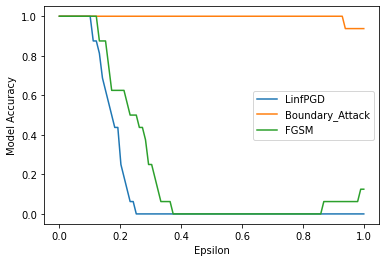

In [177]:
import matplotlib.pyplot as plt
label = ['LinfPGD', 'Boundary_Attack', 'FGSM']
for success, labels in zip(succes_rates, label):
    robust_accuracy = 1 - success.float32().mean(axis=-1)
    plt.plot(epsilon, robust_accuracy.numpy(), label=labels)
    plt.xlabel("Epsilon")
    plt.ylabel("Model Accuracy")
    plt.legend()

In [ ]:
robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
print("robust accuracy for perturbations with")
for eps, acc in zip(epsilon, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")
#print(robust_accuracy)

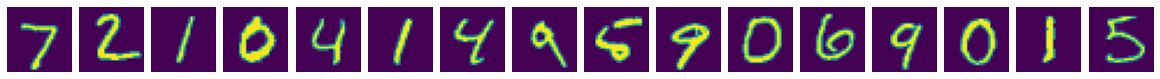

In [108]:
fb.plot.images(images)

In [68]:
# if not used as eagerpy tensor follow this
robust_accuracy = 1 - is_adv.cpu().numpy().astype(np.float32()).mean(axis=-1)
robust_accuracy

1.0